In [1]:
using PyPlot, Revise, Korg, BenchmarkTools, ProgressMeter

Precompiling Korg
  ✓ Korg
  1 dependency successfully precompiled in 62 seconds. 141 already precompiled.


In [2]:
geslines = Korg.get_GES_linelist();

┌ Warning: This function is may fail on some systems. See https://github.com/ajwheeler/Korg.jl/issues/309 for details.
└ @ Korg ~/Dropbox/Korg/src/linelist.jl:619


In [19]:
alllines = filter(geslines) do line
    4980 < line.wl*1e8 < 5020
end
length(alllines)

274383

In [20]:
A_X = format_A_X()
atm = interpolate_marcs(3000, 4.5, A_X)
;

In [21]:
cntmsol = synthesize(atm, [], A_X, 5000, 5000)
α_cntm = [_->a for a in copy(cntmsol.alpha)] # lambda per layer
n_dicts = [Dict(k => cntmsol.number_densities[k][i] for k in keys(cntmsol.number_densities)) for i in 1:56]
;

In [ ]:
max_alpha_ratio = @showprogress map(alllines) do line
    α = zeros(size(cntmsol.alpha))

    Korg.line_absorption!(α, [line], [5e-5:1e-10:5e-5], Korg.get_temps(atm),
                          cntmsol.electron_number_density, cntmsol.number_densities,
                          Korg.default_partition_funcs, 1e5, α_cntm, cutoff_threshold=1e-30)
    maximum(α ./ cntmsol.alpha)
end
;

Progress: 100%|█████████████████████████████████████████| Time: 0:00:09


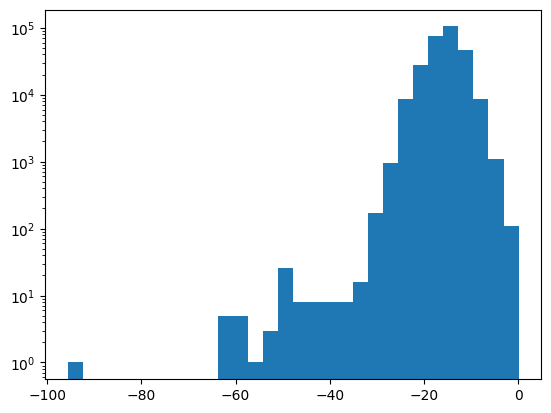

In [23]:
hist(log10.(max_alpha_ratio), bins=30)
yscale("log")

In [25]:
fewerlines = alllines[max_alpha_ratio .> 1e-5]

409-element Vector{Korg.Line{Float64, Float64, Float64, Float64, Float64, Float64}}:
 Fe I 4980.080886 Å (log gf = -0.95)
 Ni I 4981.555577 Å (log gf = 0.07)
 Ti I 4983.120493 Å (log gf = 0.57)
 Fe I 4983.889597 Å (log gf = 0.16)
 Na I 4984.204281 Å (log gf = -0.92)
 Fe I 4984.640797 Å (log gf = -0.12)
 Fe I 4985.243157 Å (log gf = -0.01)
 Ni I 4985.506927 Å (log gf = 0.31)
 Fe I 4986.643729 Å (log gf = -0.45)
 Fe I 4986.937707 Å (log gf = -1.33)
 Fe I 4987.613787 Å (log gf = -1.29)
 Nd I 4990.031829 Å (log gf = -0.03)
 Fe I 4990.341712 Å (log gf = -0.89)
 ⋮
 Ni I 5012.335856 Å (log gf = -0.68)
 Fe I 5013.466157 Å (log gf = -2.64)
 Fe I 5013.55518 Å (log gf = -0.98)
 Ni I 5013.836155 Å (log gf = -0.53)
 Fe I 5013.839156 Å (log gf = -1.11)
 Ti I 5014.678379 Å (log gf = 0.12)
 Cr I 5014.711388 Å (log gf = -0.77)
 Ti I 5015.58472 Å (log gf = -1.22)
 Ti I 5015.674844 Å (log gf = 0.04)
 Fe I 5016.341221 Å (log gf = -0.18)
 Ti I 5017.560045 Å (log gf = -0.48)
 Ni I 5018.967519 Å (log gf = -0

In [31]:
unique(line.species for line in fewerlines)

19-element Vector{Korg.Species}:
 Fe I
 Ni I
 Ti I
 Na I
 Nd I
 Ca I
 HMg
 Ce I
 OV
 OZr
 Mn I
 HSi
 Nd II
 Cr I
 OTi
 CN
 Sc I
 V I
 Si I

In [32]:
@btime solall = synthesize(atm, alllines, A_X, 5000, 5000)
@btime solfewer = synthesize(atm, fewerlines, A_X, 5000, 5000)
@btime synthesize(atm, [], A_X, 5000, 5000)
;

  570.051 ms (1189632 allocations: 455.80 MiB)
  275.157 ms (784570 allocations: 411.18 MiB)
  272.153 ms (783340 allocations: 411.04 MiB)


In [27]:
[solall.flux/solall.cntm solfewer.flux./solfewer.cntm]

1×2 Matrix{Float64}:
 0.808612  0.808632

In [28]:
[solall.flux solfewer.flux]

1×2 Matrix{Float64}:
 1.43755e13  1.43759e13

# save lines

In [44]:
using CSV, DataFrames

In [ ]:
df = DataFrame(
    wl=[line.wl for line in fewerlines],
    log_gf=[line.log_gf for line in fewerlines],
    species=[string(line.species) for line in fewerlines],
    E_lower=[line.E_lower for line in fewerlines],
    gamma_rad=[line.gamma_rad for line in fewerlines],
    gamma_stark=[line.gamma_stark for line in fewerlines],
    vdW=[line.vdW for line in fewerlines]
    )

CSV.write("alpha_5000_lines.csv", df)

"alpha_5000_lines.csv"

In [71]:
@btime Korg._load_alpha_5000_linelist()

  1.121 ms (16186 allocations: 794.00 KiB)


409-element Vector{Korg.Line{Float64, Float64, Float64, Float64, Float64, Float64}}:
 Fe I 4980.080886 Å (log gf = -0.95)
 Ni I 4981.555577 Å (log gf = 0.07)
 Ti I 4983.120493 Å (log gf = 0.57)
 Fe I 4983.889597 Å (log gf = 0.16)
 Na I 4984.204281 Å (log gf = -0.92)
 Fe I 4984.640797 Å (log gf = -0.12)
 Fe I 4985.243157 Å (log gf = -0.01)
 Ni I 4985.506927 Å (log gf = 0.31)
 Fe I 4986.643729 Å (log gf = -0.45)
 Fe I 4986.937707 Å (log gf = -1.33)
 Fe I 4987.613787 Å (log gf = -1.29)
 Nd I 4990.031829 Å (log gf = -0.03)
 Fe I 4990.341712 Å (log gf = -0.89)
 ⋮
 Ni I 5012.335856 Å (log gf = -0.68)
 Fe I 5013.466157 Å (log gf = -2.64)
 Fe I 5013.55518 Å (log gf = -0.98)
 Ni I 5013.836155 Å (log gf = -0.53)
 Fe I 5013.839156 Å (log gf = -1.11)
 Ti I 5014.678379 Å (log gf = 0.12)
 Cr I 5014.711388 Å (log gf = -0.77)
 Ti I 5015.58472 Å (log gf = -1.22)
 Ti I 5015.674844 Å (log gf = 0.04)
 Fe I 5016.341221 Å (log gf = -0.18)
 Ti I 5017.560045 Å (log gf = -0.48)
 Ni I 5018.967519 Å (log gf = -0